# DeepLabV3 Studies - Static Images

This notebook has my notes and code used while working through the Google repository for the `DeepLabV3` Object segmentation model. It is based on the sample CoLab code from the DeepLabV3 repository (see references below).

# References

This section has references to papers and code that I have used to put together this demo. Some of the code comes directly from other open source repos and in some cases I have modified it.  I have tried to give credit to all of the sources but if you see something that needs to be added, just let me know

* Google's DeepLabV3 repository. https://github.com/tensorflow/models/tree/master/research/deeplab
* Extract a mask from DeepLabV3 segmentation. https://stackoverflow.com/questions/52113864/extract-image-segmentation-map-from-tensorflow-deeplab-v3-demo
* Transfer learning using DeepLabV3. https://expoundai.wordpress.com/2019/08/30/transfer-learning-for-segmentation-using-deeplabv3-in-pytorch/
ipython widgets. https://ipywidgets.readthedocs.io/en/latest/
* Google Colab off the shelf notebook to test DeepLabV3. https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb
* Python `tempfile` module. https://docs.python.org/2/library/tempfile.html
* Python `urlib` module. https://docs.python.org/2/library/urllib.html

# Requirements

The software requirements for this notebook to run (Python packages) are in the `dlv3tf` conda environment. Some specific things:

* This notebook uses Tensor Flow 1.x, more specifically 1.15. Tensor Flow 2.0 is released, but this notebook (and Google's current (main branch) DeepLabV3 code only works with TF 1.15.

# Environment

In [46]:
import os
import sys
import tarfile
import urllib
import pathlib

from io import BytesIO

from IPython import display
from ipywidgets import interact
from ipywidgets import interactive
from matplotlib import gridspec

from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

In [2]:
print("Using TensorFlow Version:", tf.__version__)

Using TensorFlow Version: 1.15.0


The sample page for the DeepLabV3 has a Colab notebook that has a class to implement the model and run inference. At this time I am going to just re-use the code from the Google page here. Most everybody that I have seen simply re-uses this code, there is really nothing more than I can add.  

I may, however simplity it or slightly adapt it for my configuration.  In any case much of the code in the next section (`class DeepLab` model comes from https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb)

In [12]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map

# Visualization Utilities
(From the Google Colab sample notebook)

In [29]:
def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

Function to visualize results

In [ ]:
def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)



For this notebook, I will use (first) the Xception backend. It will have to be downloaded. The Colab notebook from Google has some code that allows you to choose a pre-trained model. Since at some point I will want to try other models, I will use use that code

In [13]:
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

Set the next variable to the name of the model that we want to run. 

In [14]:
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'

Where we want to store the downloaded model. The Google notebook uses a directory in `\tmp`

In [15]:
MODEL_DIR = 'tfmodels/'
model_dir = MODEL_DIR

In [16]:
download_path = os.path.join(model_dir, _TARBALL_NAME)
print("Model will be downloaded to:", download_path)

Model will be downloaded to: tfmodels/deeplab_model.tar.gz


In [17]:
print(_MODEL_URLS[MODEL_NAME])

deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz


In [18]:
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

downloading model, this might take a while...
download completed! loading DeepLab model...


# Test Loaded Model

Download the model. It gets downloaded to a `tmp` directory in `\tmp\<generated temp file name>`

In [19]:
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

model loaded successfully!


running deeplab on image http://4.bp.blogspot.com/-hPOG3rgtdoc/UAcZVeeoS1I/AAAAAAAAA6Q/NwI6Ftk_OTs/s1600/catpicturess%2B(11).jpg...


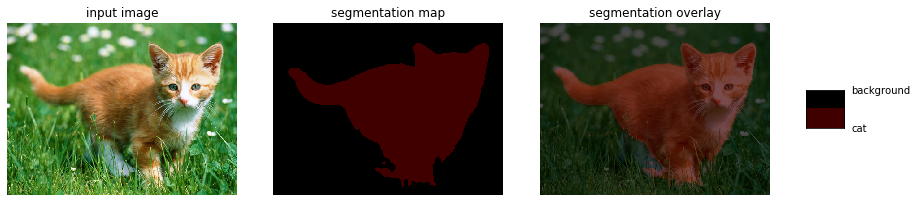

In [36]:
# Test it on a ramdom image from searching for "cat" on Google
IMAGE_URL = 'http://4.bp.blogspot.com/-hPOG3rgtdoc/UAcZVeeoS1I/AAAAAAAAA6Q/NwI6Ftk_OTs/s1600/catpicturess%2B(11).jpg'

image_url = IMAGE_URL
run_visualization(image_url)

running deeplab on image https://cdn.vox-cdn.com/thumbor/Nm3k-L83RK_PbiU-UNkMhmj59wg=/0x0:2961x1974/1200x800/filters:focal(1139x312:1611x784)/cdn.vox-cdn.com/uploads/chorus_image/image/63935159/1146487811.jpg.0.jpg...


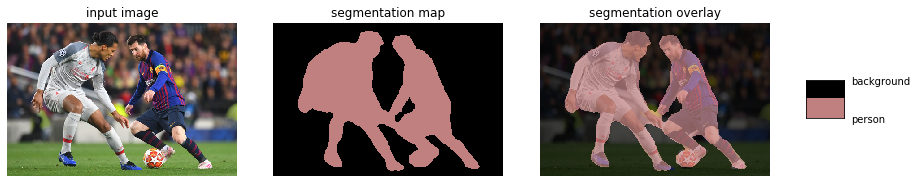

In [37]:
# Test it on a Messi Image
IMAGE_URL = 'https://cdn.vox-cdn.com/thumbor/Nm3k-L83RK_PbiU-UNkMhmj59wg=/0x0:2961x1974/1200x800/filters:focal(1139x312:1611x784)/cdn.vox-cdn.com/uploads/chorus_image/image/63935159/1146487811.jpg.0.jpg'

image_url = IMAGE_URL
run_visualization(image_url)

running deeplab on image https://cdn-img.health.com/sites/default/files/styles/medium_16_9/public/image/simone-biles.jpg?itok=9PHVbTjO...


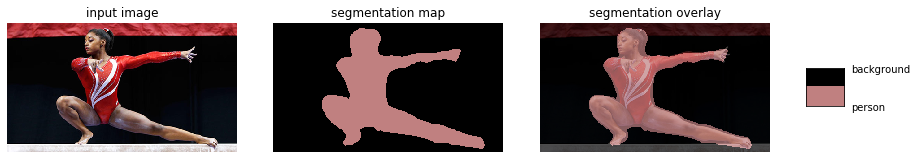

In [38]:
# Test it on a gymnast image
IMAGE_URL = 'https://cdn-img.health.com/sites/default/files/styles/medium_16_9/public/image/simone-biles.jpg?itok=9PHVbTjO'

image_url = IMAGE_URL
run_visualization(image_url)

In [60]:
# Code to convert a file path to URL since the sample code wants URLS
from urllib.parse import urljoin
from urllib.request import pathname2url

def path2url(path):
    return urljoin('file:', pathname2url(path))


In [72]:
IMAGE = '/mnt/work/dev/dlv3tf/test/images/gymnast.jpg'
#IMAGE = 'test/images/gymnast.jpg'

image_url = path2url(IMAGE); print(image_url)

file:///mnt/work/dev/dlv3tf/test/images/gymnast.jpg


running deeplab on image file:///mnt/work/dev/dlv3tf/test/images/gymnast.jpg...


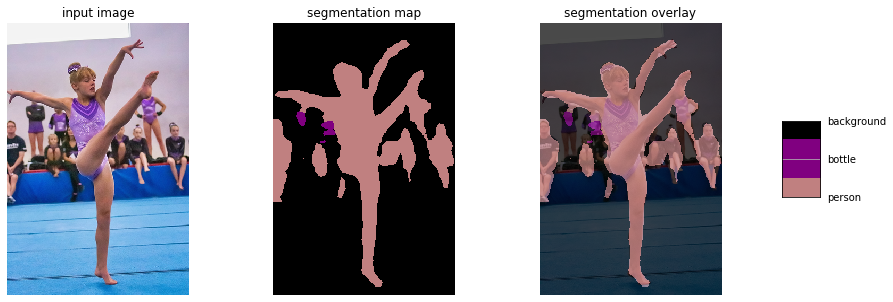

In [71]:
run_visualization(image_url)